# Setup

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from time import time
import numpy as np
import matplotlib.pyplot as plt

spark = SparkSession.builder.master('local[*]').getOrCreate()
#spark.conf.set('spark.cores.max', '1')
#spark.conf.set('spark.driver.memory','1000M')

sc = spark.sparkContext

spark

In [2]:
!pip install psutil
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 8.1 gigabytes of available RAM



# Part 1: Finding the most frequent trip using three different methods (DataFrames, Spark SQL, and RDDs)

**In this first part, we will implement and compare the efficiency of the three different methods covered in class. We will use data provided by the New York TLC (Taxi and Limousine Commission) and focus on the most frequently taken taxi trips over previous years.**

### A) DataFrames

In [3]:
#We define this files list to facilitate file selection
files = [
    "data/yellow_tripdata_2020-01.parquet",
    "data/yellow_tripdata_2020-02.parquet",
    "data/yellow_tripdata_2020-03.parquet",
    "data/yellow_tripdata_2020-04.parquet",
    "data/yellow_tripdata_2020-05.parquet",
    "data/yellow_tripdata_2020-06.parquet",
    "data/yellow_tripdata_2020-07.parquet",
    "data/yellow_tripdata_2020-08.parquet",
    "data/yellow_tripdata_2020-09.parquet",
    "data/yellow_tripdata_2020-10.parquet",
    "data/yellow_tripdata_2020-11.parquet",
    "data/yellow_tripdata_2020-12.parquet",
    
    "data/yellow_tripdata_2021-01.parquet",
    "data/yellow_tripdata_2021-02.parquet",
    "data/yellow_tripdata_2021-03.parquet",
    "data/yellow_tripdata_2021-04.parquet",
    "data/yellow_tripdata_2021-05.parquet",
    "data/yellow_tripdata_2021-06.parquet",
    "data/yellow_tripdata_2021-07.parquet",
    "data/yellow_tripdata_2021-08.parquet",
    "data/yellow_tripdata_2021-09.parquet",
    "data/yellow_tripdata_2021-10.parquet",
    "data/yellow_tripdata_2021-11.parquet",
    "data/yellow_tripdata_2021-12.parquet",

    "data/yellow_tripdata_2022-01.parquet",
    "data/yellow_tripdata_2022-02.parquet",
    "data/yellow_tripdata_2022-03.parquet",
    "data/yellow_tripdata_2022-04.parquet",
    "data/yellow_tripdata_2022-05.parquet",
    "data/yellow_tripdata_2022-06.parquet",
    "data/yellow_tripdata_2022-07.parquet",
    "data/yellow_tripdata_2022-08.parquet",
    "data/yellow_tripdata_2022-09.parquet",
    "data/yellow_tripdata_2022-10.parquet",
    "data/yellow_tripdata_2022-11.parquet",
    "data/yellow_tripdata_2022-12.parquet",

    "data/yellow_tripdata_2019-01.parquet",
    "data/yellow_tripdata_2019-02.parquet",
    "data/yellow_tripdata_2019-03.parquet",
    "data/yellow_tripdata_2019-04.parquet",
    "data/yellow_tripdata_2019-05.parquet",
    "data/yellow_tripdata_2019-06.parquet",
    "data/yellow_tripdata_2019-07.parquet",
    "data/yellow_tripdata_2019-08.parquet",
    "data/yellow_tripdata_2019-09.parquet",
    "data/yellow_tripdata_2019-10.parquet",
    "data/yellow_tripdata_2019-11.parquet",
    "data/yellow_tripdata_2019-12.parquet",


    "data/yellow_tripdata_2023-01.parquet",
    "data/yellow_tripdata_2023-02.parquet",
    "data/yellow_tripdata_2023-03.parquet",
    "data/yellow_tripdata_2023-04.parquet",
    "data/yellow_tripdata_2023-05.parquet",
    "data/yellow_tripdata_2023-06.parquet",
    "data/yellow_tripdata_2023-07.parquet",
    "data/yellow_tripdata_2023-08.parquet",
    "data/yellow_tripdata_2023-09.parquet",
    "data/yellow_tripdata_2023-10.parquet",
    "data/yellow_tripdata_2023-11.parquet",
    "data/yellow_tripdata_2023-12.parquet",
]

**For the first three parts, which involve performing the analysis using the three methods, we will focus on the data from 2020, 2021, and 2022. For the subsequent parts, which involve comparing the efficiency of each method, we will also include data from 2019 and 2023.**

In [4]:
selected_files = files[:36]

**Let's start by reading the data files**

In [5]:
df1 = spark.read.csv('taxi_zone_lookup.csv', header=True, inferSchema=True)

In [6]:
df2 = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load(selected_files)

**Here is the structure of the tables we are using**

In [7]:
df1.printSchema()

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



In [8]:
df2.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: integer (nullable = true)



**To make the analysis easier to understand, we will perform a double join between these two tables to associate the PickUp and DropOff zone IDs with their corresponding zone names.**

In [9]:
#Duplicate the ID/Zone mapping DataFrame to perform the double join
df1_pu = df1.withColumnRenamed("Zone", "PULocation")
df1_do = df1.withColumnRenamed("Zone", "DOLocation")

joined1 = df2.join(df1_pu, df2["PULocationID"] == df1_pu["LocationID"])

joined = joined1.join(df1_do, joined1["DOLocationID"] == df1_do["LocationID"])

In [10]:
joined.select("PULocation", "DOLocation").show(10)

+--------------------+--------------------+
|          PULocation|          DOLocation|
+--------------------+--------------------+
|Upper West Side N...|Upper West Side S...|
|Upper West Side S...|Upper West Side N...|
|Upper West Side N...|Upper West Side N...|
|Upper West Side N...|    Manhattan Valley|
|Queensbridge/Rave...|Queensbridge/Rave...|
|             Astoria|Queensbridge/Rave...|
|Queensbridge/Rave...|Queensbridge/Rave...|
|Queensbridge/Rave...|Queensbridge/Rave...|
|Queensbridge/Rave...|Queensbridge/Rave...|
|West Chelsea/Huds...|        Clinton East|
+--------------------+--------------------+
only showing top 10 rows


**Now, our "joined" DataFrame correctly lists the PickUp and DropOff zones with their corresponding names. The first 10 rows are displayed above.**

**Next, we will find the most frequent trips using "groupBy" followed by "count" and then "sort"**

In [11]:
grouped = joined.groupBy("PULocation", "DOLocation").count()

In [12]:
result = grouped.sort(grouped["count"].desc())

In [13]:
result.show(10)

+--------------------+--------------------+------+
|          PULocation|          DOLocation| count|
+--------------------+--------------------+------+
|Upper East Side S...|Upper East Side N...|658213|
|Upper East Side N...|Upper East Side S...|561283|
|Upper East Side N...|Upper East Side N...|459590|
|Upper East Side S...|Upper East Side S...|454100|
|                 N/A|                 N/A|419251|
|Upper West Side S...|Upper West Side N...|258792|
|Upper East Side S...|      Midtown Center|256545|
|Upper West Side S...| Lincoln Square East|252737|
|     Lenox Hill West|Upper East Side N...|244680|
| Lincoln Square East|Upper West Side S...|244298|
+--------------------+--------------------+------+
only showing top 10 rows


**Between 2020 and 2022, the most frequent trips were between the Upper East Side South and Upper East Side North zones in Manhattan.**

**We can now examine the evolution of these trips for each year to get a better overview.**

In [14]:
top = 5 #Focus on the 5 most popular trips each year

pu_lists = [[] for i in range(top)]
do_lists = [[] for i in range(top)]
counts_lists = [[] for i in range(top)]

for i in range(20, 23):
    #Read the files
    df1 = spark.read.csv('taxi_zone_lookup.csv', header=True, inferSchema=True)
    df2 = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load(f"data/yellow_tripdata_20{i}*.parquet")

    #Join
    df1_pu = df1.withColumnRenamed("Zone", "PULocation")
    df1_do = df1.withColumnRenamed("Zone", "DOLocation")
    joined1 = df2.join(df1_pu, df2["PULocationID"] == df1_pu["LocationID"])
    joined = joined1.join(df1_do, joined1["DOLocationID"] == df1_do["LocationID"])

    
    grouped = joined.groupBy("PULocation", "DOLocation").count()
    results = grouped.sort(grouped["count"].desc()).limit(5).collect()

    #Store the top 5 trips and their counts
    for rank in range(top):
        pu_lists[rank].append(results[rank]["PULocation"])
        do_lists[rank].append(results[rank]["DOLocation"])
        counts_lists[rank].append(results[rank]["count"])

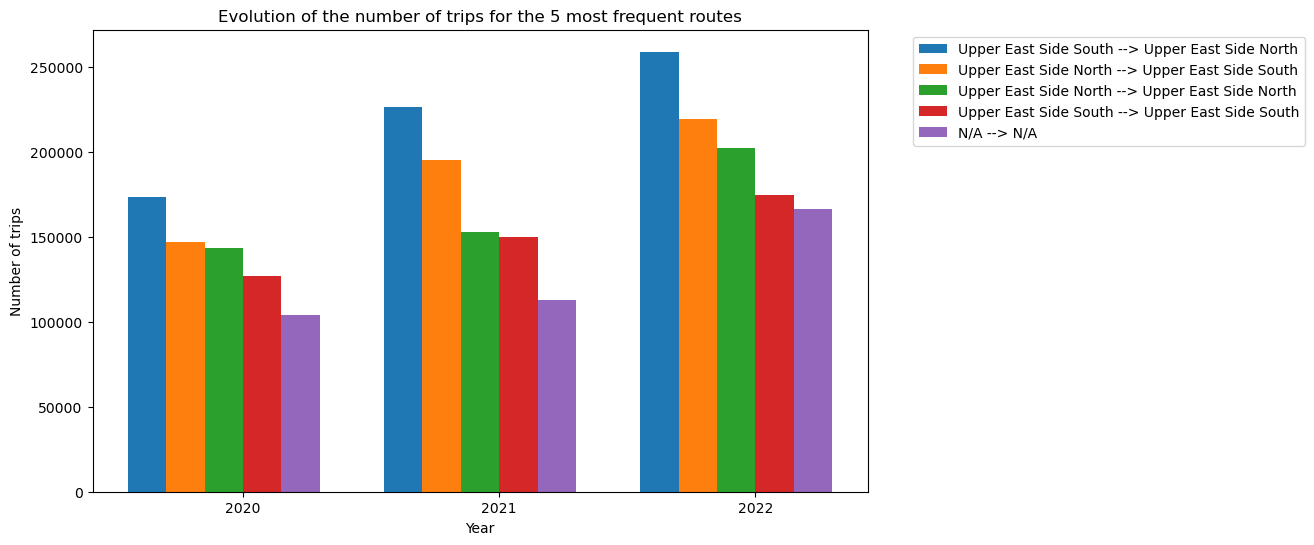

In [15]:
years = [2020, 2021, 2022]
x = np.array([i for i in range(len(years))]) #Offset for the shift
width = 0.15 


fig = plt.subplots(figsize=(10,6))

#Plot the bars for the top 5 trips
for i in range(top):
    plt.bar(x + (i - top/2) * width, counts_lists[i], width, label = pu_lists[i][0] + " --> " + do_lists[i][0])


plt.xlabel('Year')
plt.ylabel('Number of trips')
plt.title('Evolution of the number of trips for the 5 most frequent routes')

plt.legend(bbox_to_anchor=(1.05, 1))
plt.xticks(x, years)

plt.show()

**This chart confirms the overall trend. Over these three years, the trip from Upper East Side South --> Upper East Side North is the most frequent.**

**We also notice that the total number of trips increases each year. The lower count in 2020 is explained by the global COVID-19 crisis, followed by a gradual increase in subsequent years, reflecting a return to normal.**

### B) Spark SQL

**Let's start by reading the files**

In [16]:
df1 = spark.read.csv('taxi_zone_lookup.csv', header=True, inferSchema=True)

In [17]:
df2 = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load(selected_files)

**Next, let's create temporary views**

In [18]:
df1.createOrReplaceTempView("zones")
df2.createOrReplaceTempView("trips")

**Let's execute the corresponding SQL query**

In [19]:
results = spark.sql("""SELECT pu.Zone AS PULocation, do.Zone AS DOLocation, COUNT(*) AS trip_count FROM trips t
JOIN zones pu ON t.PULocationID = pu.LocationID
JOIN zones do ON t.DOLocationID = do.LocationID
GROUP BY pu.Zone, do.Zone
ORDER BY trip_count DESC
"""
)

In [20]:
results.show(10)

+--------------------+--------------------+----------+
|          PULocation|          DOLocation|trip_count|
+--------------------+--------------------+----------+
|Upper East Side S...|Upper East Side N...|    658213|
|Upper East Side N...|Upper East Side S...|    561283|
|Upper East Side N...|Upper East Side N...|    459590|
|Upper East Side S...|Upper East Side S...|    454100|
|                 N/A|                 N/A|    419251|
|Upper West Side S...|Upper West Side N...|    258792|
|Upper East Side S...|      Midtown Center|    256545|
|Upper West Side S...| Lincoln Square East|    252737|
|     Lenox Hill West|Upper East Side N...|    244680|
| Lincoln Square East|Upper West Side S...|    244298|
+--------------------+--------------------+----------+
only showing top 10 rows


**We obtain the same result as the previous method : between 2020 and 2022, the most frequent trips were between the Upper East Side South and Upper East Side North areas of Manhattan.**


**As before, let's look at the evolution of these trips over each year to get a better understanding.**

In [21]:
top = 5 #Focus on the 5 most popular trips each year

pu_lists = [[] for i in range(top)]
do_lists = [[] for i in range(top)]
c_lists = [[] for i in range(top)]


for i in range(20, 23):
    #Reading files
    df1 = spark.read.csv('taxi_zone_lookup.csv', header=True, inferSchema=True)
    df2 = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load(f"data/yellow_tripdata_20{i}*.parquet")

    #Views
    df1.createOrReplaceTempView("zones")
    df2.createOrReplaceTempView("trips")

     
    results = spark.sql("""SELECT pu.Zone AS PULocation, do.Zone AS DOLocation, COUNT(*) AS count FROM trips t
    JOIN zones pu ON t.PULocationID = pu.LocationID
    JOIN zones do ON t.DOLocationID = do.LocationID
    GROUP BY pu.Zone, do.Zone
    ORDER BY count DESC
    LIMIT 5
    """).collect()
    
    #Store the top 5 trips and their counts
    for rank in range(top):
        pu_lists[rank].append(results[rank]["PULocation"])
        do_lists[rank].append(results[rank]["DOLocation"])
        c_lists[rank].append(results[rank]["count"])

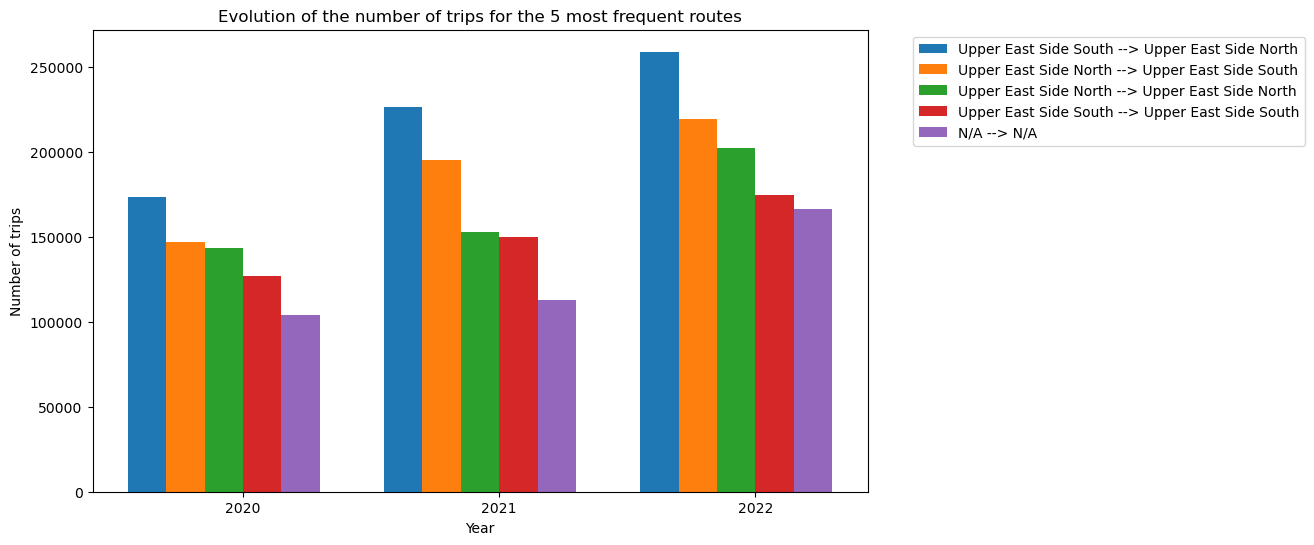

In [22]:
years = [2020, 2021, 2022]
x = np.array([i for i in range(len(years))]) #Offset for the shift
width = 0.15  

fig = plt.subplots(figsize=(10,6))

#Plot the bars for the top 5 trips
for i in range(top):
    plt.bar(x + (i - top/2) * width, c_lists[i], width, label = pu_lists[i][0] + " --> " + do_lists[i][0])


plt.xlabel('Year')
plt.ylabel('Number of trips')
plt.title('Evolution of the number of trips for the 5 most frequent routes')

plt.legend(bbox_to_anchor=(1.05, 1))
plt.xticks(x, years)

plt.show()

**We obtain the same results. Using SQL queries or DataFrames is equivalent for this analysis.**

### C) RDDs

In [3]:
files = [

    "data/yellow_tripdata_2022-01.parquet",
    "data/yellow_tripdata_2022-02.parquet",
    "data/yellow_tripdata_2022-03.parquet",
    "data/yellow_tripdata_2022-04.parquet",
    "data/yellow_tripdata_2022-05.parquet",
    "data/yellow_tripdata_2022-06.parquet",
    "data/yellow_tripdata_2022-07.parquet",
    "data/yellow_tripdata_2022-08.parquet",
    "data/yellow_tripdata_2022-09.parquet",
    "data/yellow_tripdata_2022-10.parquet",
    "data/yellow_tripdata_2022-11.parquet",
    "data/yellow_tripdata_2022-12.parquet",

]

In [4]:
selected_files = files[:6]

In [5]:
df1 = spark.read.csv('taxi_zone_lookup.csv', header=True, inferSchema=True)
rdd1 = df1.rdd.map(lambda x: (x['LocationID'], x['Zone']))


df2 = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load(selected_files)

rdd2 = df2.rdd.map(lambda x: (x['PULocationID'], x['DOLocationID']))

In [6]:
pu = rdd1
do = rdd1

joined1 = rdd2.join(pu)  

joined2 = joined1.map(lambda x: (x[1][0], (x[0], x[1][1])))

joined_full = joined2.join(do)

In [7]:
pairs = joined_full.map(lambda x: ((x[1][0][1], x[1][1]), 1))

In [8]:
counts = pairs.reduceByKey(lambda a, b: a + b)

In [ ]:
top5 = counts.sortBy(lambda x: x[1], False).take(5)

In [ ]:
for e in top5:
    print(e)

In [13]:
files6firsts = [
    
    ["data/yellow_tripdata_2020-01.parquet",
    "data/yellow_tripdata_2020-02.parquet",
    "data/yellow_tripdata_2020-03.parquet",
    "data/yellow_tripdata_2020-04.parquet",
    "data/yellow_tripdata_2020-05.parquet",
    "data/yellow_tripdata_2020-06.parquet"]
    
    ["data/yellow_tripdata_2021-01.parquet",
    "data/yellow_tripdata_2021-02.parquet",
    "data/yellow_tripdata_2021-03.parquet",
    "data/yellow_tripdata_2021-04.parquet",
    "data/yellow_tripdata_2021-05.parquet",
    "data/yellow_tripdata_2021-06.parquet"]

    ["data/yellow_tripdata_2022-01.parquet",
    "data/yellow_tripdata_2022-02.parquet",
    "data/yellow_tripdata_2022-03.parquet",
    "data/yellow_tripdata_2022-04.parquet",
    "data/yellow_tripdata_2022-05.parquet",
    "data/yellow_tripdata_2022-06.parquet"]
]

In [130]:
def RDD(n_months):

    selected_files = files[:n_months]

    df1 = spark.read.csv('taxi_zone_lookup.csv', header=True, inferSchema=True)
    rdd1 = df1.rdd.map(lambda x: (x['LocationID'], x['Zone']))
    df2 = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("mode", "DROPMALFORMED").load(selected_files)
    rdd2 = df2.rdd.map(lambda x: (x['PULocationID'], x['DOLocationID']))

    pu = rdd1
    do = rdd1
    
    joined1 = rdd2.join(pu)  
    
    joined2 = joined1.map(lambda x: (x[1][0], (x[0], x[1][1])))
    
    joined_full = joined2.join(do)

    pairs = joined_full.map(lambda x: ((x[1][0][1], x[1][1]), 1))
    counts = pairs.reduceByKey(lambda a, b: a + b)
    top5 = counts.sortBy(lambda x: x[1], False).take(5)

    return top5
    

In [16]:
res = RDD(6)
for e in res:
    print(e)

(('Upper East Side South', 'Upper East Side North'), 135238)
(('Upper East Side North', 'Upper East Side South'), 115157)
(('N/A', 'N/A'), 100359)
(('Upper East Side South', 'Upper East Side South'), 88792)
(('Upper East Side North', 'Upper East Side North'), 88574)


### D) Comparison of the DataFrame and SQL methods

**In this section, we will compare the efficiency of the 2 methods.**

**To do this, we will record and compare execution times based on the amount of input data.**

**For each method, we define a corresponding function**

In [23]:
def dataFrame(n_months):

    #Select the number of months of data to process
    selected_files = files[:n_months]

    #Read the files
    df1 = spark.read.csv('taxi_zone_lookup.csv', header=True, inferSchema=True)
    df = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load(selected_files)

    #GroupBy
    count = df.groupBy("PULocationID", "DOLocationID").count()

    #Join
    df1_pu = df1.withColumnRenamed("Zone", "PULocation")
    df1_do = df1.withColumnRenamed("Zone", "DOLocation")

    joined1 = count.join(df1_pu, count["PULocationID"] == df1_pu["LocationID"])

    joined = joined1.join(df1_do, joined1["DOLocationID"] == df1_do["LocationID"])

    #Sort
    sort = joined.sort(count["count"].desc())
    

    #Select the columns
    result = sort.select("PULocation", "DOLocation", "count")

    return result
    

In [24]:
def SQL(n_months):

    #Select the number of months of data to process
    selected_files = files[:n_months]

    #Read the files
    df1 = spark.read.csv('taxi_zone_lookup.csv', header=True, inferSchema=True)
    df2 = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load(selected_files)

    #Views creation
    df1.createOrReplaceTempView("zones")
    df2.createOrReplaceTempView("trips")

 
    result = spark.sql("""SELECT pu.Zone AS PULocation, do.Zone AS DOLocation, COUNT(*) AS count FROM trips t
    JOIN zones pu ON t.PULocationID = pu.LocationID
    JOIN zones do ON t.DOLocationID = do.LocationID
    GROUP BY pu.Zone, do.Zone
    ORDER BY count DESC
    """)

    return result
    

**First, let's look at the overall evolution of execution time as the amount of data processed increases.**

In [25]:
months = [i for i in range(1, 60, 2)]
times_df = []
times_sql = []

for i in months:
    #DataFrame time
    t0_df = time()
    dataFrame(i)
    times_df.append(np.round(time() - t0_df, 3))

    #SQL time
    t0_sql = time()
    SQL(i)
    times_sql.append(np.round(time() - t0_sql, 3))

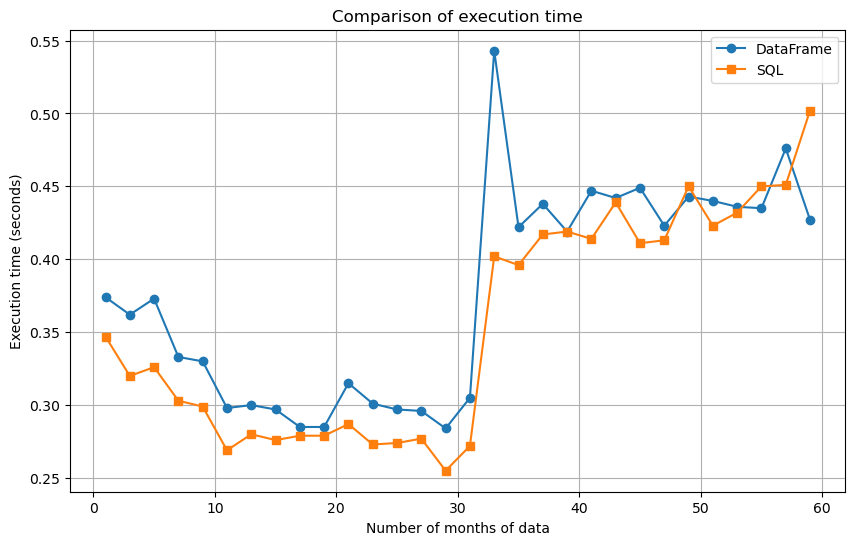

In [26]:
plt.figure(figsize=(10,6))

plt.plot(months, times_df, marker='o', label='DataFrame')
plt.plot(months, times_sql, marker='s', label='SQL')

plt.xlabel('Number of months of data')
plt.ylabel("Execution time (seconds)")
plt.title("Comparison of execution time")
plt.grid(True)
plt.legend()
plt.show()

**This chart shows that for up to 30 months of data, the execution time remains roughly constant around 0.25 seconds. After 32 months of data, the execution time nearly doubles and appears to continue increasing linearly with the amount of data.**

**The chart also shows that both methods have very similar execution times for the same amount of data.**

**Let's analyze this in more detail :**

In [27]:
months = [i for i in range(1, 60, 5)]
times_df = []
times_sql = []

for i in months:
    # Temps DataFrame
    t0_df = time()
    dataFrame(i)
    times_df.append(np.round(time() - t0_df, 3))

    # Temps SQL
    t0_sql = time()
    SQL(i)
    times_sql.append(np.round(time() - t0_sql, 3))

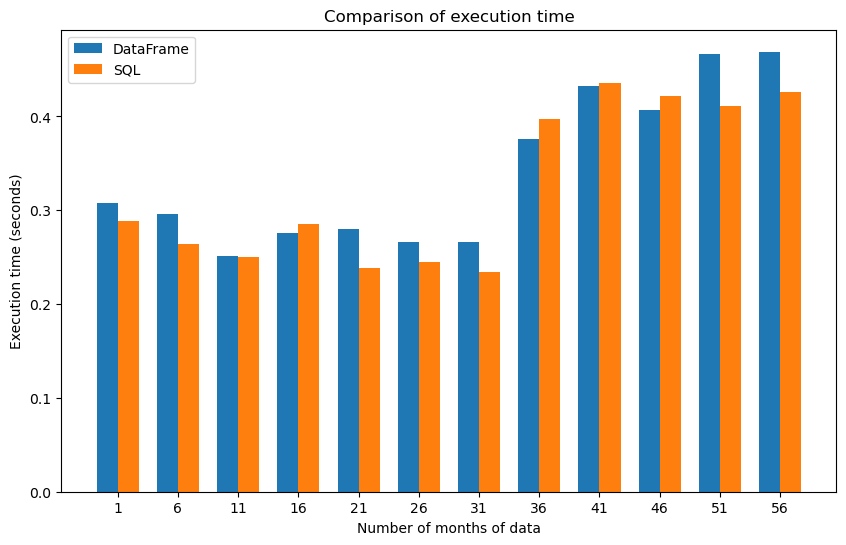

In [28]:
x = np.array([i for i in range(len(months))])
width = 0.35


fig = plt.subplots(figsize=(10,6))

plt.bar(x - width/2, times_df, width, label='DataFrame')
plt.bar(x + width/2, times_sql, width, label='SQL')


plt.xlabel('Number of months of data')
plt.ylabel("Execution time (seconds)")
plt.title("Comparison of execution time")
plt.xticks(x,months)
plt.legend()

plt.show()

**Let's calculate the average execution ratios**

In [29]:
ratios = np.array(times_sql) / np.array(times_df)

#Average of ratios
mean_ratio = np.mean(ratios)

print("Average ratio of execution times (SQL / DataFrame) :", mean_ratio)

Average ratio of execution times (SQL / DataFrame) : 0.9499955558242478


**The ratio is very close to 1, so we can conclude that, for this study, using DataFrames or SQL queries is almost equivalent.**

### E) Analysis of the speedup evolution with the number of processors

**Now, let's examine the effect of increasing the number of processors on processing speed.**

1  -->  0.5186688899993896
2  -->  0.5198646386464437
3  -->  0.44879953066507977
4  -->  0.48890137672424316


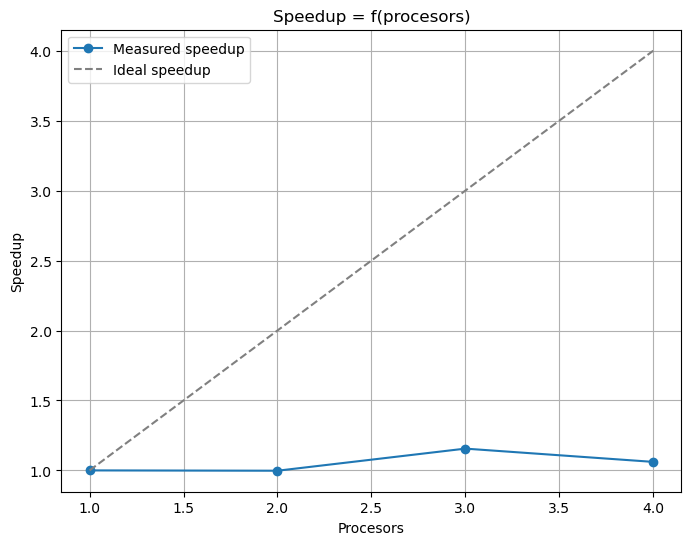

In [30]:

cores = [1, 2, 3, 4]  
runs = 3              
months = 60        
times = []

for core in cores:
    spark = SparkSession.builder.master('local[core]').getOrCreate()


    #Average over multiple runs due to high variability
    run_times = []
    for i in range(runs):
        t0 = time()
        dataFrame(months) 
        run_times.append(time() - t0)
    
    avg_time = np.mean(run_times)
    times.append(avg_time)
    
    print(core, " --> ", avg_time)

#Speedup
speedup = []
for i in range(len(times)):
    speedup.append(times[0]/times[i])

plt.figure(figsize=(8,6))
plt.plot(cores, speedup, 'o-', label='Measured speedup')
plt.plot(cores, cores, '--', color='gray', label='Ideal speedup')

plt.xlabel('Procesors')
plt.ylabel('Speedup')
plt.title('Speedup = f(procesors)')
plt.legend()
plt.grid(True)
plt.show()

## Introduction

This analysis investigates tipping behavior in taxi rides. We wanted to see if the number of passengers in a car affects the average tip percentage given at the end of the ride. By analyzing a large dataset of trips, we compared the average tips for groups of different sizes (specifically, rides with one to six passengers) to identify any clear patterns or differences.

## First implementation

We first load the data using the Parquet parser of Spark.

In [67]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql import functions as F

spark = SparkSession.builder.master('local[2]').getOrCreate()
df = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("data/*.parquet")
print("Number of trips:",df.count())
df.printSchema()

Number of trips: 179807942
root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: integer (nullable = true)



In the Spark UI, we can see that loading the data took 0.418 milliseconds.

In [61]:
df.select("PULocationID", "DOLocationID", "tip_amount", "passenger_count", "total_amount") \
    .filter(df["total_amount"] > 0) \
    .withColumn("tip_percent", (F.col("tip_amount") / F.col("total_amount") * 100)) \
    .groupBy("passenger_count") \
    .agg(F.avg("tip_percent").alias("avg_tip_percent")).orderBy(F.desc("avg_tip_percent")) \
    .show()

+---------------+------------------+
|passenger_count|   avg_tip_percent|
+---------------+------------------+
|           NULL|60.063419331989465|
|          112.0|16.666666666666664|
|           96.0|13.043478260869568|
|            1.0| 11.40766087844835|
|            5.0|11.352980006859077|
|            6.0|11.309975849139262|
|            2.0|11.118978531585393|
|            0.0|11.036427380815713|
|            3.0|    10.88123160406|
|            4.0|10.170780710575505|
|            8.0| 9.690808621531673|
|            9.0| 9.566487658538772|
|            7.0| 9.419216760568446|
+---------------+------------------+



Spark UI shows that this operation took 11 seconds.

This first analysis of the tips is not accurate because of incorrect data. Some trips have no passenger number (NULL) or impossible numbers, like 96 or 112. These strange figures made the calculation of the average tip wrong.

## Second implementation

To fix this and get more accurate results, we filter the data to only keep rides with a normal number of passengers, specifically between 1 and 6. This removes the unrealistic trips. Then, we count the total number of rides for each passenger group. We then decided to only keep groups that had more than 1,000 rides. This makes sure our average is based on a large amount of data, not just a few trips.

df.select("PULocationID", "DOLocationID", "tip_amount", "passenger_count", "total_amount") \
    .filter(df["total_amount"] > 0) \
    .withColumn("tip_percent", (F.col("tip_amount") / F.col("total_amount") * 100)) \
    .filter(F.col("passenger_count").between(1, 6)) \
    .groupBy("passenger_count") \
    .agg(F.count("*").alias("nb_courses"),F.avg("tip_percent").alias("avg_tip_percent")) \
    .filter(F.col("nb_courses") > 1000) \
    .orderBy(F.desc("avg_tip_percent")) \
    .show()

Spark UI shows that this operation also took 11 seconds. This shows that the complexity of the operation is far from being the bottleneck of the processing time, instead it is the data size.

## Conclusion

Based on the analysis, the number of passengers has a small but clear effect on tipping habits.

Our results show that single passengers (1.0) gave the highest average tips, at 11.41%. The lowest tips came from groups of four passengers (4.0), who tipped an average of 10.17% of total amount. While the differences are not massive, the data clearly indicates that traveling alone or in a group of four impacts the final tip percentage.

Spark's DataFrame allowed us to handle over 179 million rides for this analysis. We chained commands like .select(), .filter(), and .groupBy() to create a clear and logical "recipe" for our task. This approach is easy to read and efficient, allowing Spark to handle all the difficult work of processing such a huge volume of data.
